Based on the <font color=red>underlying mechanism of cumulative fatigue damage theory</font>, accumulate experimental data to test component properties.

## 1.

Attempting to fit traditional fragility curves, which inherently assumes that destruction is only related to the instantaneous intensity

In [1]:
import numpy as np
from scipy.stats import norm, lognorm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

with open("fragility_experiments_data2.pkl", 'rb') as file:
    dataset = pickle.loads(file.read())
    fragility_only_ins = dataset["fragility_only_ins"]

In [2]:
def lognormal_cdf(x, mu, sigma):
    return norm.cdf((np.log(x) - mu) / sigma)

x = [key for key in fragility_only_ins.keys()]
y = [np.mean(fragility_only_ins[key]) for key in fragility_only_ins.keys()]

x = np.asarray(x)
y = np.asarray(y)
mask = x > 0
x_filtered = x[mask]
y_filtered = y[mask]
epsilon = 1e-6
y_filtered = np.clip(y_filtered, epsilon, 1 - epsilon)

# Step 1: Initial parameter estimation using linear regression
z = norm.ppf(y_filtered)
ln_x = np.log(x_filtered)
coeffs = np.polyfit(z, ln_x, 1)
sigma_initial, mu_initial = coeffs[0], coeffs[1]

# Step 2: Parameter optimization via nonlinear fitting (scipy.optimize.curve_fit)
p0 = [mu_initial, sigma_initial]
params, _ = curve_fit(lognormal_cdf, x_filtered, y_filtered, p0=p0)
mu_fit, sigma_fit = params

# Print the fitting result
print(f"Fitting Result: mu = {mu_fit:.8f}, sigma = {sigma_fit:.8f}")

Fitting Result: mu = 3.97110346, sigma = 0.09959508


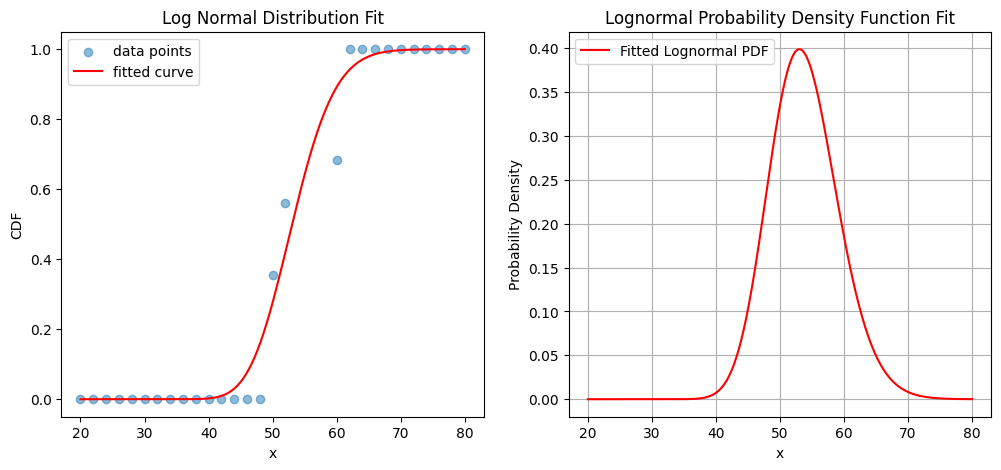

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# CDF Plot
x_vals = np.linspace(20, 80, 500)
y_fit_curve = lognormal_cdf(x_vals, mu_fit, sigma_fit)
ax1.scatter(x_filtered, y_filtered, label='data points', alpha=0.5)
ax1.plot(x_vals, y_fit_curve, 'r-', label='fitted curve')
ax1.set_xlabel('x')
ax1.set_ylabel('CDF')
ax1.legend()
ax1.set_title('Log Normal Distribution Fit')
# PDF Plot
x_pdf = np.linspace(20, 80, 500)
y_pdf = norm.pdf((np.log(x_pdf) - mu_fit) / sigma_fit)
ax2.plot(x_pdf, y_pdf, label='Fitted Lognormal PDF', color='red')
ax2.set_title('Lognormal Probability Density Function Fit')
ax2.set_xlabel('x')
ax2.set_ylabel('Probability Density')
ax2.legend()
ax2.grid(True)
plt.show()

## 2.

A specific model of the cumulative fatigue damage mechanism is assumed to be known, but its parameters are unknown.

Using a series of wind speed sequences and state sequences, the parameters of the cumulative fatigue damage mechanism are estimated using Maximum Likelihood Estimation (MLE).

In [4]:
import numpy as np
from scipy.optimize import differential_evolution
import random
import pickle

random_seed = 3407
np.random.seed(random_seed)
random.seed(random_seed)

TARGET_DELTAT = 3 / 3600
TARGET_DELTAT_sci_str = "{:.2e}".format(TARGET_DELTAT)

In [5]:
with open("fragility_experiments_data2.pkl", 'rb') as file:
    dataset = pickle.loads(file.read())

In [6]:
def compute_negative_log_likelihood(params, data):
    dt_sec = 3
    
    a, b, Dres, v0, vmax = params
    w_sequence_dataset = data["w_sequence_raw"]
    s_sequence_dataset = data["s_sequence_raw"]

    # Parameter validity check
    if any(para <= 0 for para in [a, b, Dres]) or (v0 >= vmax):
        return np.inf  # Return infinity to penalize invalid parameters
    
    total_log_likelihood = 0.0
    epsilon = 1e-10  # Numerical stability constant
    big_M = np.inf  # Large value
    
    for i in range(0, len(w_sequence_dataset), 50):
        w = w_sequence_dataset[i] # Wind speed sequence i
        s = s_sequence_dataset[i] # State sequence i
        for k in range(0, len(w), 1000):
            s_k = s[k] # Observed state
            w_to_k = w[0:k] # Historical wind speeds up to time k
            w_geq_v0 = w_to_k[w_to_k >= v0] # Only wind speeds > v0 contribute to fatigue damage
            cumulative = np.sum(a * np.exp(b * w_geq_v0 * w_geq_v0) * (dt_sec / 3600)) if k > 0 else 0.0 # Cumulative damage value

            # Calculate theoretical conditional damage probability
            w_k = w[k]
            if w_k >= vmax:
                P_d = 1.0
            else:
                D = 0 if w_k<=v0 else a*np.exp(b*w_k*w_k)
                denom = Dres - cumulative - D * (dt_sec/3600) 
                if denom <= 0:
                    P_d = 1.0
                else:
                    to_exp = D*(dt_sec/3600) / denom
                    P_d = 1.0 - np.exp(-to_exp)
            
            # Calculate likelihood contribution
            if s_k >= 1 - epsilon:
                if P_d <= epsilon:
                    # Theoretical damage probability is 0 but damage observed, likelihood = -infinity
                    total_log_likelihood += (-big_M)
                else:
                    # Damage observed, accumulate damage probability
                    total_log_likelihood += np.log(P_d)
            else:
                if P_d >= 1 - epsilon:
                    # Theoretical damage probability is 1 but undamaged observed, likelihood = -infinity
                    total_log_likelihood += (-big_M)
                else:
                    # Undamaged observed, accumulate survival probability
                    total_log_likelihood += np.log(1 - P_d)
    # Return negative log-likelihood for minimization
    return -total_log_likelihood


# Define callback function
def monitor_progress(intermediate_result):
    iteration_counter[0] += 1
    current_best_params = intermediate_result.x
    current_best_objective = intermediate_result.fun

    iteration_params.append(current_best_params)
    iteration_objectives.append(current_best_objective)

    # Print
    print(f"Iteration {iteration_counter[0]}: Best Objective = {current_best_objective:.6f}")
    print(f"a={current_best_params[0]:.4e}, b={current_best_params[1]:.4e}, Dres={current_best_params[2]:.4e}, v0={current_best_params[3]:.2f}, vmax={current_best_params[4]:.2f}")

    return False

# List to store iteration results
iteration_objectives = []
iteration_params = []
iteration_counter = [0] # Using list to allow modification in callback function

In [7]:
# Define bounds for parameter optimization
bounds = [
        (1e-8, 2e-7),
        (1e-3, 6e-3),
        (2e-1, 1e0),
        (0, 30),
        (30, 60)
]
# Use scipy.optimize.differential_evolution
result = differential_evolution(
    compute_negative_log_likelihood,
    bounds,
    args=(dataset,),
    strategy='best1bin',
    maxiter=500-200,
    popsize=25,
    tol=1e-8,
    mutation=(0.5, 1),
    recombination=0.7,
    seed=random_seed,
    callback=monitor_progress,
)

Iteration 1: Best Objective = 3920.451069
a=9.2540e-08, b=5.6839e-03, Dres=2.5112e-01, v0=12.41, vmax=55.13
Iteration 2: Best Objective = 3202.765963
a=1.8914e-07, b=5.4656e-03, Dres=2.1474e-01, v0=11.16, vmax=55.80
Iteration 3: Best Objective = 3202.765963
a=1.8914e-07, b=5.4656e-03, Dres=2.1474e-01, v0=11.16, vmax=55.80
Iteration 4: Best Objective = 3202.765963
a=1.8914e-07, b=5.4656e-03, Dres=2.1474e-01, v0=11.16, vmax=55.80
Iteration 5: Best Objective = 3202.765963
a=1.8914e-07, b=5.4656e-03, Dres=2.1474e-01, v0=11.16, vmax=55.80
Iteration 6: Best Objective = 3202.765963
a=1.8914e-07, b=5.4656e-03, Dres=2.1474e-01, v0=11.16, vmax=55.80
Iteration 7: Best Objective = 3202.765963
a=1.8914e-07, b=5.4656e-03, Dres=2.1474e-01, v0=11.16, vmax=55.80
Iteration 8: Best Objective = 2510.049856
a=1.8857e-07, b=5.5354e-03, Dres=2.3207e-01, v0=11.40, vmax=53.59
Iteration 9: Best Objective = 2267.859819
a=1.9285e-07, b=5.4650e-03, Dres=2.0176e-01, v0=5.64, vmax=50.72
Iteration 10: Best Objective 

In [8]:
para_id_result = {
    'a': result.x[0],
    'b': result.x[1],
    'Dres': result.x[2],
    'v0': result.x[3],
    'vmax' : result.x[4]
}

from pprint import pprint
pprint(para_id_result)

{'Dres': 0.20033761790684773,
 'a': 1.917974392013611e-07,
 'b': 0.005502413917601797,
 'v0': 19.465035610201653,
 'vmax': 53.14449273773345}


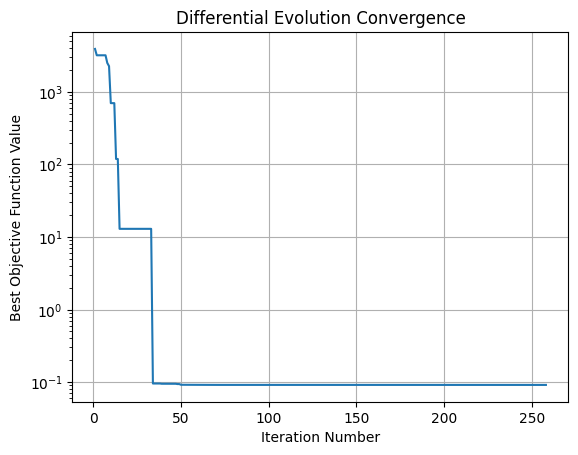

In [9]:
import matplotlib.pyplot as plt

# Objective Function Iteration Curve
plt.plot(range(1, len(iteration_objectives) + 1), iteration_objectives, linestyle='-')
plt.xlabel("Iteration Number")
plt.ylabel("Best Objective Function Value")
plt.title("Differential Evolution Convergence")
plt.grid(True)
plt.yscale('log')
plt.show()